In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
# from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline

In [45]:
# INITIALIZING SQLLITE
import sqlite3

DATABASE_PATH = './data/sf/database.sqlite'
conn = sqlite3.connect(DATABASE_PATH)
cursor = conn.cursor()

In [46]:
def run_query(query):
    cursor.execute(query)
    return cursor.fetchall()

def run_pd_query(query):
    return pd.read_sql(query, conn)

### Taking a closer look at our database

In [47]:
# SQL query to obtain all of the weather information
WEATHER_QUERY = 'SELECT * FROM weather;'
weather_df = run_pd_query(WEATHER_QUERY)

In [48]:
# SQL query to create a row for each trip and the start and end station
TRIP_STATION_QUERY = 'SELECT * FROM trip'
sf_df = run_pd_query(TRIP_STATION_QUERY)


In [49]:
# remove any rows that have empty columns
sf_df = sf_df.dropna(how="any")
weather_df = weather_df.dropna(how="any")

In [50]:
# remove the outliers based on duration
z_scores = stats.zscore(sf_df["duration"])

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
sf_df = sf_df[filtered_entries]

In [51]:
# convert the start and end dates to pandas datetime
sf_df["start_date"] = pd.to_datetime(sf_df["start_date"], format='%m/%d/%Y %H:%M')
sf_df["end_date"] = pd.to_datetime(sf_df["end_date"], format='%m/%d/%Y %H:%M')

weather_df["date"] = pd.to_datetime(weather_df["date"], format='%m/%d/%Y')

# add month column
sf_df["month"] = sf_df["start_date"].dt.month
sf_df["end_month"] = sf_df["end_date"].dt.month
weather_df["month"] = weather_df["date"].dt.month

# add year column
sf_df["year"] = sf_df["start_date"].dt.year
weather_df["year"] = weather_df["date"].dt.year


sf_df["week"] = sf_df["start_date"].dt.isocalendar().week
weather_df["week"] = weather_df["date"].dt.isocalendar().week

# add day column
sf_df["day"] = sf_df["start_date"].dt.day
sf_df["day_of_year"] = sf_df["start_date"].dt.day_of_year
weather_df["day"] = weather_df["date"].dt.day


# add hour column
sf_df["hour"] = sf_df["start_date"].dt.hour

# make duration into minutes
sf_df["duration_min"] = sf_df["duration"] / 60

In [52]:
sf_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,month,end_month,year,week,day,day_of_year,hour,duration_min
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,8,8,2013,35,29,241,9,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,8,8,2013,35,29,241,9,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,8,8,2013,35,29,241,9,18.850000
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122,8,8,2013,35,29,241,9,18.616667
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597,8,8,2013,35,29,241,9,18.633333


In [53]:
weather_df.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code,month,year,week,day
0,2013-08-29,74,68,61,61,58,56,93,75,57,...,28,0,4,,286,94107,8,2013,35,29
1,2013-08-30,78,69,60,61,58,56,90,70,50,...,35,0,2,,291,94107,8,2013,35,30
2,2013-08-31,71,64,57,57,56,54,93,75,57,...,31,0,4,,284,94107,8,2013,35,31
3,2013-09-01,74,66,58,60,56,53,87,68,49,...,29,0,4,,284,94107,9,2013,35,1
4,2013-09-02,75,69,62,61,60,58,93,77,61,...,30,0,6,,277,94107,9,2013,36,2


In [54]:
weather_df.columns

Index(['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'events', 'wind_dir_degrees', 'zip_code', 'month',
       'year', 'week', 'day'],
      dtype='object')

In [55]:
float_cols = ['max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'wind_dir_degrees']
weather_df[float_cols] = weather_df[float_cols].apply(pd.to_numeric, errors="coerce")

feature_cols = ['max_temperature_f', 'max_visibility_miles',
        'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches']
weather_df = weather_df.drop(set(float_cols).difference(feature_cols), axis=1)

In [56]:
weather_df = weather_df.dropna()

In [57]:
# sf_usage = sf_df.groupby(["month", "day", "start_station_id"]).agg(usage=('id', 'count')).reset_index(drop=False)
# sf_usage['ewm'] = sf_usage.groupby(['start_station_id'])[["usage"]].transform(lambda x: x.ewm(halflife=7).mean())


In [58]:
sf_usage = (
    sf_df.groupby(["month", "day", "year", "start_station_id"]).agg(
        usage=('id', 'count'),
        week=("week", "min"),
        date=("start_date", "min"),
    )
).reset_index(drop=False)
weather_aggregated = (
    weather_df.drop("date", axis=1).groupby(["month", "day", "year"]).agg({i: "mean" for i in feature_cols}).reset_index()
)
sf_usage = sf_usage.merge(weather_aggregated, on=["month", "day", "year"])
sf_usage["is_weekend"] = sf_usage["date"].dt.day_of_week > 5
# lag not currently used
sf_usage["lag1_weekend"]= (sf_usage["date"] - pd.Timedelta(days=1)).dt.day_of_week > 5
sf_usage["usage_lag"] = sf_usage["usage"].shift(1)
sf_usage["lag2_weekend"]= (sf_usage["date"] - pd.Timedelta(days=2)).dt.day_of_week > 5
sf_usage["usage_lag2"] = sf_usage["usage"].shift(2)

sf_usage = sf_usage.dropna()

In [59]:
train, test = train_test_split(sf_usage, test_size=0.2)


In [60]:
train

,month,day,year,start_station_id,usage,week,date,max_temperature_f,max_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,is_weekend,lag1_weekend,usage_lag,lag2_weekend,usage_lag2
43014,12,30,2013,11,1,1,2013-12-30 23:35:00,61.60,10.0,9.60,1.60,0.0000,False,True,2.0,False,1.0
15819,5,14,2015,75,34,20,2015-05-14 07:11:00,65.25,10.0,15.25,5.25,0.2675,False,False,50.0,False,22.0
32582,9,28,2014,4,2,39,2014-09-28 15:56:00,74.20,11.0,16.00,6.20,0.0000,True,False,1.0,False,4.0
40495,12,5,2014,57,24,49,2014-12-05 07:45:00,66.00,10.0,16.00,6.40,0.0280,False,False,23.0,False,43.0
15247,5,10,2014,58,2,19,2014-05-10 09:17:00,68.40,10.0,24.80,10.60,0.0000,False,False,10.0,False,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,1,6,2015,34,3,2,2015-01-06 08:41:00,61.75,9.5,6.50,1.50,0.0000,False,False,2.0,True,2.0
12760,4,20,2014,14,3,16,2014-04-20 12:28:00,78.80,11.0,17.40,5.20,0.0000,True,False,1.0,False,8.0
36527,10,31,2014,47,8,44,2014-10-31 08:47:00,63.20,10.0,13.60,5.80,0.1940,False,False,4.0,False,16.0
29845,9,5,2013,58,12,36,2013-09-05 09:35:00,77.20,10.0,22.80,9.00,0.0000,False,False,12.0,False,11.0


In [61]:
# When doing inference, we should be able to have previous data for this station at previous months.
# This isn't cheating / leaking info because it's just a way of characterizing which station we're using
# And we're still maintaining the train test split.. right?
group_keys = ["month", 'start_station_id', "is_weekend"]
train_station_data = (
    train.groupby(group_keys).agg(
        avg_usage=('usage', 'mean'),
        min_usage=('usage', 'min'),
        max_usage=('usage', 'max'),
    )
).reset_index(drop=False)


# train_station_data = impute(train_station_data, "avg_usage")
# train_station_data = impute(train_station_data, "min_usage")
# train_station_data = impute(train_station_data, "max_usage")

In [62]:
# # features that give properties of each station instead of the station id
# weather_agg = {i: (i, "mean") for i in float_cols}
# train_df = (
#     train.groupby(["month", "day", 'start_station_id']).agg(
#         date=("date", "min"),
#         avg_usage=("usage", "mean"),
#         usage_lag=("usage_lag", "mean"),
#         **weather_agg
#     )
# ).reset_index(drop=False)

# test_df = (
#     test.groupby(["month", "day", 'start_station_id']).agg(
#         date=("date", "min"),
#         avg_usage=("usage", "mean"),
#         usage_lag=("usage_lag", "mean"),
#         is_weekend=("usage_lag", "mean"),
#         **weather_agg
#     )
# ).reset_index(drop=False)

In [63]:
# train_df = train_df.merge(train_station_data, on=["month", "day", "start_station_id"])
# test_df = test_df.merge(train_station_data, on=["month", "day", "start_station_id"], how="left")

In [64]:
def impute(df, col):
    df[col] = df.groupby(group_keys[:-1]).transform(lambda x: x.fillna(x.mean()))[col]
    return df



def prep_df(df):
    df = df.merge(train_station_data, on=group_keys, how="left")
    if any(df.isna()):
        df = impute(df, "avg_usage")
        df = impute(df, "min_usage")
        df = impute(df, "max_usage")
    df_tmp = df.drop(["start_station_id", "date", "year", "week"], axis=1).dropna()
    X = df_tmp[[i for i in df_tmp.columns if i != "usage"]]
    # X = (X-X.mean())/X.std()
    y = df_tmp["usage"]
    return X, y, df

In [65]:
X_tr, y_tr, train = prep_df(train)
X_te, y_te, test = prep_df(test)

In [23]:
X_tr

,month,day,max_temperature_f,max_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,is_weekend,lag1_weekend,usage_lag,lag2_weekend,usage_lag2,avg_usage,min_usage,max_usage
0,3,23,66.80,12.0,13.60,5.0,0.0,True,False,1.0,False,1.0,2.000000,1,5
1,7,6,77.25,10.0,19.75,9.0,0.0,False,True,3.0,False,6.0,2.764706,1,8
2,5,5,65.80,10.0,17.80,7.8,0.0,False,False,1.0,True,6.0,2.947368,1,8
3,5,30,67.00,10.0,21.20,9.0,0.0,False,False,16.0,False,27.0,15.171429,3,23
4,7,10,70.00,10.0,14.00,7.5,0.0,False,False,16.0,False,38.0,34.108696,6,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34564,10,31,71.60,10.0,10.60,2.4,0.0,False,False,25.0,False,23.0,40.219512,9,60
34565,6,21,69.00,11.0,16.20,6.4,0.0,False,False,8.0,False,6.0,21.351351,1,34
34566,8,22,76.60,10.0,16.60,6.8,0.0,False,False,1.0,False,2.0,6.214286,1,10
34567,7,13,77.00,10.0,20.20,9.2,0.0,False,True,2.0,False,3.0,6.097561,1,13


In [24]:
X_te[X_te.isna().any(axis=1)]

,month,day,max_temperature_f,max_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,is_weekend,lag1_weekend,usage_lag,lag2_weekend,usage_lag2,avg_usage,min_usage,max_usage


In [25]:
X_te = X_te.dropna()

In [26]:
regressors = {
    "Lasso": Lasso(alpha=0.1),
    "Decision Tree (max depth 10)": DecisionTreeRegressor(max_depth=10),
    "Decision Tree (max depth 20)": DecisionTreeRegressor(max_depth=20),
    "KNeighborsRegressor (neighbors 3)": KNeighborsRegressor(n_neighbors=3),
    "KNeighborsRegressor (neighbors 5)": KNeighborsRegressor(n_neighbors=5),
    "GradientBoostingRegressor": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=7, random_state=0,
        loss='squared_error'
    )

}
linear = LinearRegression().fit(X_tr, y_tr)
yhat = linear.predict(X_te)
mse = mean_squared_error(y_te, yhat)
best = {"mse": mse, "model": linear, "name": "Linear"}
print(f"Linear: {mse}")

for name, model in regressors.items():
    reg = model.fit(X_tr, y_tr)
    yhat = reg.predict(X_te)
    mse = mean_squared_error(y_te, yhat)
    mae = mean_absolute_error(y_te, yhat)
    if mse < best["mse"]:
        best["mse"] = mse
        best["mae"] = mae

        best["model"] = reg
        best["name"] = name

    print(f"{name} - MSE: {mse}")
    print(f"{name} - MAE: {mae}")
    print()
best

Linear: 75.34580915708293
Lasso - MSE: 75.99630450481934
Lasso - MAE: 5.244548440456221

Decision Tree (max depth 10) - MSE: 42.90820231599476
Decision Tree (max depth 10) - MAE: 4.076241427075703

Decision Tree (max depth 20) - MSE: 56.83001558861096
Decision Tree (max depth 20) - MAE: 4.674037766715455

KNeighborsRegressor (neighbors 3) - MSE: 43.018884903647134
KNeighborsRegressor (neighbors 3) - MAE: 4.226156041497936

KNeighborsRegressor (neighbors 5) - MSE: 39.30108064329516
KNeighborsRegressor (neighbors 5) - MAE: 4.023302094180261

GradientBoostingRegressor - MSE: 29.460115545532794
GradientBoostingRegressor - MAE: 3.504163064866572



{'mse': 29.460115545532794,
 'model': GradientBoostingRegressor(max_depth=7, n_estimators=300, random_state=0),
 'name': 'GradientBoostingRegressor',
 'mae': 3.504163064866572}

In [27]:
import pickle
with open("best_model.pkl", "wb+") as f:
    pickle.dump(best, f)

In [69]:
with open("training_data.pkl", "wb+") as f:
    pickle.dump(train, f)
    
with open("test_data.pkl", "wb+") as f:
    pickle.dump(test, f)
    
with open("sf_usage.pkl", "wb+") as f:
    pickle.dump(sf_usage, f)

In [29]:
data = {"weights": linear.coef_, "col": X_tr.columns}
importance = pd.DataFrame(data=data)
importance = importance.sort_values("weights", ascending=False)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'lag2_weekend'),
  Text(1, 0, 'lag1_weekend'),
  Text(2, 0, 'is_weekend'),
  Text(3, 0, 'avg_usage'),
  Text(4, 0, 'usage_lag')])

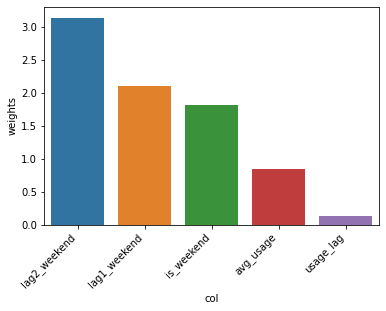

In [30]:
sns.barplot(data=importance[:5], x="col", y="weights")
plt.xticks(rotation=45, ha="right")

In [31]:
importance

,weights,col
10,3.141026,lag2_weekend
8,2.097787,lag1_weekend
7,1.819156,is_weekend
12,0.849284,avg_usage
9,0.123743,usage_lag
11,0.078332,usage_lag2
13,0.052085,min_usage
3,0.036987,max_visibility_miles
2,0.030511,max_temperature_f
14,0.028035,max_usage


In [73]:
yhat = best["model"].predict(X_te)
with open("yhat.pkl", "wb+") as f:
    pickle.dump(yhat, f)
with open("y_te.pkl", "wb+") as f:
    pickle.dump(y_te, f)

<AxesSubplot:xlabel='usage', ylabel='Count'>

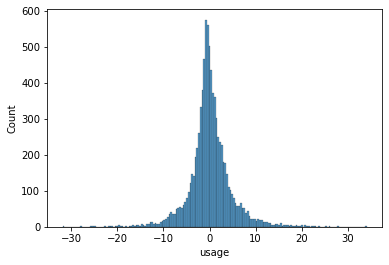

In [72]:
sns.histplot(y_te - yhat)

In [68]:
stations = pd.read_csv("data/sf/station.csv")
stations

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013
...,...,...,...,...,...,...,...
65,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013
66,80,Santa Clara County Civic Center,37.352601,-121.905733,15,San Jose,12/31/2013
67,82,Broadway St at Battery St,37.798541,-122.400862,15,San Francisco,1/22/2014
68,83,Mezes Park,37.491269,-122.236234,15,Redwood City,2/20/2014
